In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import keras
from models import model_v2
from tensor_dlt import TensorDLT
from spatial_transformer import spatial_transformer_network

In [16]:
# dataset
from pathlib import Path
from DataGenerator import DataGenerator

batch_size=1
def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(batch_size)
    return ds

# training set data generator
root = "/home/ji/Dropbox/Robotics/CMSC733/Project1"
train_path = Path(root) / "Phase2" / "Data" / "Train"
train_gen = DataGenerator(train_path,mode="unsupervised_test")

# tensorflow dataset
im_crop_shape = (train_gen.crop_size,train_gen.crop_size,3)
im_ori_shape = (train_gen.resize_shape[1],train_gen.resize_shape[0],3)

output_signature_test=( (tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),#input
                    tf.TensorSpec(shape=im_crop_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32),
                    tf.TensorSpec(shape=(2,),dtype=tf.float32),
                    tf.TensorSpec(shape=(8,),dtype=tf.float32),
                    ),
                     
                     tf.TensorSpec(shape=im_ori_shape,dtype=tf.float32) # output
                    )

train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature_test)

train_ds = config_ds(train_ds)

sample_input, sample_output = next(iter(train_ds))

print("input shapes:")
for i in sample_input:
    print(i.shape)
print("output shape")
print(sample_output.shape)

input shapes:
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 240, 320, 3)
(1, 2)
(1, 8)
output shape
(1, 240, 320, 3)


In [17]:
# set up fake model
# feed the homography net output to the TensorDLT to recover actual homography
homography = TensorDLT(h4pt_batch=sample_input[-1],
                       upper_left_corner=sample_input[-2],
                       batch_size=batch_size)

# use spatial transformer to get predicted image
img_pred = spatial_transformer_network(sample_input[2],
                                       homography,
                                       img_height=im_ori_shape[0],
                                       img_width=im_ori_shape[1],
                                       )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


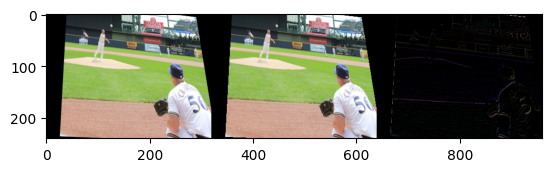

In [19]:
import matplotlib.pyplot as plt
import numpy as np

im_ori = np.squeeze(sample_output.numpy())/255.
im_pred = np.squeeze(img_pred.numpy())/255.
plt.imshow(np.hstack((im_ori, im_pred, im_ori-im_pred)))
plt.show()